In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
from datetime import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt 

### Loading Price Data

In [2]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
src_path = os.path.join(project_root, "src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

from create_Dataframe import createDataframe as create_df
merged_data_summer = create_df('summer')

print(merged_data_summer.head())
merged_data_summer.head()

#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12


            timestamp  Spotmarket_(EUR/kWh)  Inflexible_Demand_(kWh)  \
0 2023-08-01 00:00:00               0.07165                 0.076260   
1 2023-08-01 01:00:00               0.06910                 0.077891   
2 2023-08-01 02:00:00               0.06682                 0.077230   
3 2023-08-01 03:00:00               0.06406                 0.077059   
4 2023-08-01 04:00:00               0.06407                 0.076241   

   PV_energy_production_kWh  ev_at_home_binary  distance_driven  \
0                       0.0                  1              0.0   
1                       0.0                  1              0.0   
2                       0.0                  1              0.0   
3                       0.0                  1              0.0   
4                       0.0                  1              0.0   

   ev_home_availability  weekday  
0                   1.0        1  
1                   1.0        1  
2                   1.0        1  
3                   1.0 

/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


,timestamp,Spotmarket_(EUR/kWh),Inflexible_Demand_(kWh),PV_energy_production_kWh,ev_at_home_binary,distance_driven,ev_home_availability,weekday
0,2023-08-01 00:00:00,0.07165,0.076260,0.0,1,0.0,1.0,1
1,2023-08-01 01:00:00,0.06910,0.077891,0.0,1,0.0,1.0,1
2,2023-08-01 02:00:00,0.06682,0.077230,0.0,1,0.0,1.0,1
3,2023-08-01 03:00:00,0.06406,0.077059,0.0,1,0.0,1.0,1
4,2023-08-01 04:00:00,0.06407,0.076241,0.0,1,0.0,1.0,1


### Dishwasher

In [3]:
# Load data
price = merged_data_summer["Spotmarket_(EUR/kWh)"].values
inflexibles = merged_data_summer["Inflexible_Demand_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"min_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")
    


Set parameter Username
Set parameter LicenseID to value 2653942
Academic license - for non-commercial use only - expires 2026-04-17


### Washing Machine

In [4]:
model.update()
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if washing machine is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the washing machine in a single week and '>= 1' day ensures that the washing machine has to run 4 times per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7 -1)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_WM_summer'] = 0  # Initialize with 0


# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 1
    else: 
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 0

        
model.addConstrs((binary_wm[t] <= merged_data_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")
#model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later




{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### Dryer 

In [5]:
### including the dryer
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked


binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# Binary start variables: 1 if dryer starts at hour t

start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t

binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 

for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")

for t in range(len(start_times_dryer)-duration_dryer):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")


# Enforce minimum gap of 0 hours and max gap of 2 hours between two end of washing machine and start of dryer



# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")



#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_dryer_summer'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 0

        
model.addConstrs((binary_dryer[t] <= merged_data_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")
#model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### EV - G2V

In [6]:
# Include EV
#EV properties

min_power_ev = 1 #kW, minimum power to charge the EV
max_power_ev = 10 #kW, maximum power to charge the EV
kwh_per_km = 0.2  # kWh per km driven

max_capacity_ev = 70 #kWh

#Variables
#state of charge of the EV at each time step
soc_ev = model.addVars(Time_interval,lb=0, ub=max_capacity_ev, vtype=GRB.CONTINUOUS, name="soc_ev")
#how much power is being charged at each time step
charging_ev = model.addVars(Time_interval,lb=0, ub=max_power_ev, vtype=GRB.CONTINUOUS, name="charging_lvl_ev")
#binary variable to indicate if the EV is being charged at each time step
charging_binary_ev = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_ev")


# Enforce SoC at 7:00 every day (hour 7 of each day)
for d in range(Time_interval // 24):
    t = d * 24 + 7  # 7:00 each day
    if t < Time_interval:
        model.addConstr(soc_ev[t] >= 0.8*max_capacity_ev, name=f"ev_soc_7am_day_{d}")

# car can only charge if it is at home
model.addConstrs((charging_binary_ev[t] <= merged_data_summer['ev_at_home_binary'][t] for t in range(len(charging_binary_ev))), name="allowed_ev_summer")

# if car is at home, it can charge, but not more than the maximum power
# and if it is charging, it must be charging at least the minimum power
model.addConstrs((charging_ev[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * charging_binary_ev[t] for t in range(Time_interval)), name="max_power_ev")
model.addConstrs((charging_ev[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * charging_binary_ev[t] for t in range(Time_interval)), name="min_power_ev")

# Constrain ev storage

initial_soc_ev = 20
model.addConstr(soc_ev[0] == initial_soc_ev, name="ev_soc_initial")



<gurobi.Constr *Awaiting Model Update*>

### PV and V2G

In [7]:
#for power produced with the PV system, the price is one half of the spot market price
merged_data_summer['feed_in_tariff'] = merged_data_summer['Spotmarket_(EUR/kWh)'] * 0.8


ev_v2h_feed_in_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="ev_v2h_feed_in_binary")  # z[t] = 1 if EV is feeding in power
#add constraint, ev cant be charging and feeding in power at the same time
model.addConstrs((ev_v2h_feed_in_binary[t] + charging_binary_ev[t] <= 1 for t in range(Time_interval)), name="ev_v2h_feed_in_binary_constraint")
#add variable for ev if power is being fed into the grid
ev_feed_in_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="ev_feed_in_binary")  # z[t] = 1 if EV is feeding in power
#add constraint, ev cant be charging and feeding in power at the same time 
model.addConstrs((ev_feed_in_binary[t] + charging_binary_ev[t] <= 1 for t in range(Time_interval)), name="ev_feed_in_binary_constraint")
#add variable of power being fed into the grid by the EV
ev_feed_in_power = model.addVars(Time_interval, lb=0.0, name="ev_feed_in_power")  # Power fed into the grid by EV
ev_v2h_power = model.addVars(Time_interval, lb=0.0, name="ev_v2h_power")  # Power fed into the grid by EV in V2H mode

# if car is at home, it can feed-in, but not more than the maximum power
# and if it is feeding-in, it must be discharging at least the minimum power
model.addConstrs((ev_v2h_power[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * ev_v2h_feed_in_binary[t] for t in range(Time_interval)), name="max_power_ev_v2h_feed_in")
model.addConstrs((ev_v2h_power[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * ev_v2h_feed_in_binary[t] for t in range(Time_interval)), name="min_power_ev_v2h_feed_in")
model.addConstrs((ev_feed_in_power[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * ev_feed_in_binary[t] for t in range(Time_interval)), name="max_power_ev_feed_in")
model.addConstrs((ev_feed_in_power[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * ev_feed_in_binary[t] for t in range(Time_interval)), name="min_power_ev_feed_in")

#added up, the feed in is not allowed to be higher than the power introduced by the EV
model.addConstrs((ev_feed_in_power[t] + ev_v2h_power[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] for t in range(Time_interval)), name="ev_feed_in_power_limit")
#add constraint for state of charge of the EV
model.addConstrs((soc_ev[t] == soc_ev[t-1] + charging_ev[t-1] - ev_feed_in_power[t] - ev_v2h_power[t] - merged_data_summer['distance_driven'][t-1] * kwh_per_km for t in range(1,Time_interval)),name="ev_soc_update")

#add variable for total load minus the power produced by the PV system
#add gurobi variable that finds the min between load and pv production

# Total power consumption including fixed and dishwasher
total_load = {
    t: merged_data_summer['Inflexible_Demand_(kWh)'][t]+
       power_dishwasher * binary_dishwasher[t] +
       power_wm * binary_wm[t] + power_dryer * binary_dryer[t] + charging_ev[t]
    for t in range(Time_interval)
}


pv_maxed_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="pv_maxed")  # z[t] = 1 if load >= pv
M = 10000 #1.2 * merged_data_summer['PV_energy_production_kWh'].max() # Choose M large enough to cover max difference between pv and load
unmet   = model.addVars(Time_interval, lb=0.0, name="unmet_load")
pv_feed_in = model.addVars(Time_interval, lb=0.0, name="feed_in")

for t in range(Time_interval):
    pv = merged_data_summer['PV_energy_production_kWh'][t]
    load = total_load[t]
    
    # Binary switch: if PV > load → binary = 0; else 1
    model.addConstr(pv + ev_v2h_power[t] - load + unmet[t] - pv_feed_in[t] == 0, name=f"pv_load_balance_{t}")
    model.addConstr(pv_feed_in[t] <= (1-pv_maxed_binary[t]) * M , name=f"curtail_pv_{t}_2")
    model.addConstr(unmet[t] <= pv_maxed_binary[t] * M, name=f"unmet_load_{t}_2")



### Peak Price 
If everyone implements this optimization, the price will have to be higher at peak times 

In [18]:
model.update()
ε = 1e-3
wanted_steps = 3
max_demand = max(inflexibles) + power_dishwasher + power_wm + power_dryer + max_power_ev
levels = np.arange(0, max_demand/2 + ε, max_demand/((wanted_steps -1)*2))
levels = np.append(levels, max_demand * 1.5 + 5)  # Ensure coverage

#multipllier for penalty costs per level increasing by 0.1 per level
multiplier_per_level = [0.05 * i for i in range(len(levels)-1)]
M_price = max_demand + 10

# Binary indicators per level per timestep
level_bin = [
    [model.addVar(vtype=GRB.BINARY, name=f"level_bin[{t},{i}]") for i in range(len(levels)-1)]
    for t in range(Time_interval)
]

# Integer index of active level
demand_level = [
    model.addVar(lb=0, ub=len(levels) - 1, vtype=GRB.INTEGER, name=f"demand_level[{t}]")
    for t in range(Time_interval)
]

# Total demand per timestep
total_demand = model.addVars(Time_interval, lb=0, ub=max_demand, vtype=GRB.CONTINUOUS, name="total_demand")

# Constraint: calculate total demand
for t in range(Time_interval):
    model.addConstr(
        total_demand[t] ==
        unmet[t], name=f"total_demand_from_grid_calc_{t}"
    )

# Constraint: only one level active at a time
for t in range(Time_interval):
    model.addConstr(gp.quicksum(level_bin[t]) == 1, name=f"one_level_active_{t}")

# Constraint: bind total_demand to its level using Big-M
for t in range(Time_interval):
    for i in range(len(levels) - 1):
        model.addConstr(
            total_demand[t] >= levels[i] - (1 - level_bin[t][i]) * M_price,
            name=f"lower_bound_level_{t}_{i}"
        )
        model.addConstr(
            total_demand[t] <= levels[i + 1] - ε + (1 - level_bin[t][i]) * M_price,
            name=f"upper_bound_level_{t}_{i}"
        )
    # Calculate demand_level from binary selection
    model.addConstr(
        demand_level[t] == gp.quicksum(i * level_bin[t][i] for i in range(len(levels)-1)),
        name=f"demand_level_calc_{t}"
    )

#generate penalty costs for each level that depend on a const and a linear term
penalty_per_level = [multiplier_per_level[i] * levels[i] for i in range(len(levels)-1)]



# Penalty term as an expression
penalty_cost = gp.quicksum(
    penalty_per_level[i] * level_bin[t][i]
    for t in range(Time_interval)
    for i in range(len(levels)-1)
)

print(levels)
print(multiplier_per_level)
print(penalty_per_level)

[ 0.          5.32008676 10.64017351 36.92052054]
[0.0, 0.05, 0.1]
[0.0, 0.2660043378280649, 1.0640173513122595]


### Objective Function and Optimization

do we have a system where PV can be fed into the system and money is earned or not...
-> change the price if needed
as implemented now: V2G and PV feed into the grid at the same price. 

In [10]:
# Objective: minimize total electricity cost including penalty
model.setObjective(
    gp.quicksum(
        price[t] * unmet[t]
        - ev_feed_in_power[t] * merged_data_summer['feed_in_tariff'][t]
        - pv_feed_in[t] * merged_data_summer['feed_in_tariff'][t]
        for t in range(Time_interval)
    ) + penalty_cost,
    GRB.MINIMIZE
)

model.update()
model.optimize()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 28324 rows, 17852 columns and 78847 nonzeros
Model fingerprint: 0xeddedb2f
Variable types: 5208 continuous, 12644 integer (11900 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+04]
  Objective range  [2e-03, 9e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e-04, 1e+04]

MIP start from previous solve produced solution with objective 0.344558 (0.15s)
MIP start from previous solve produced solution with objective 0.344558 (0.15s)
Loaded MIP start from previous solve with objective 0.344558

Presolve removed 17036 rows and 8362 columns
Presolve time: 0.90s
Presolved: 11288 rows, 9490 columns, 40210 nonzeros
Variable types: 3431 continuous, 6059 integer (6059 binary)

Root relaxation: objective -4.430157e+00, 3890 iterations, 0.08

### Debugging

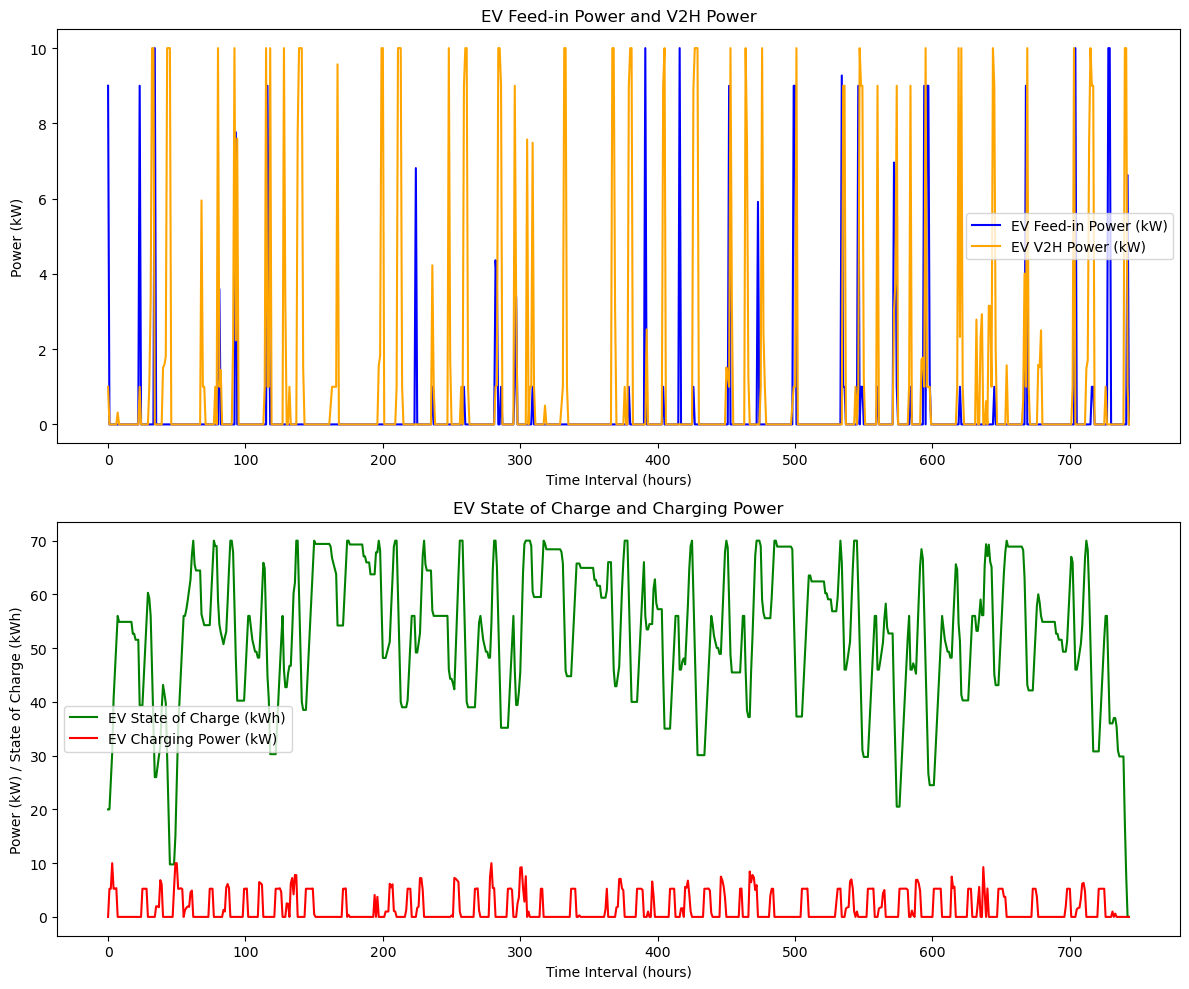

No optimal solution found. Status code: 11


In [11]:
#plot amount of power being fed into grid and into home by ev and another plot with state of charge and power consuption of ev
import matplotlib.pyplot as plt
# Extract results
ev_feed_in_power_values = [ev_feed_in_power[t].X for t in range(Time_interval)]
ev_v2h_power_values = [ev_v2h_power[t].X for t in range(Time_interval)]
soc_ev_values = [soc_ev[t].X for t in range(Time_interval)]
charging_ev_values = [charging_ev[t].X for t in range(Time_interval)]
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
# Plot EV feed-in power and V2H power
axs[0].plot(ev_feed_in_power_values, label='EV Feed-in Power (kW)', color='blue')   
axs[0].plot(ev_v2h_power_values, label='EV V2H Power (kW)', color='orange')
axs[0].set_title('EV Feed-in Power and V2H Power')
axs[0].set_xlabel('Time Interval (hours)')
axs[0].set_ylabel('Power (kW)')
axs[0].legend()
# Plot EV state of charge and charging power
axs[1].plot(soc_ev_values, label='EV State of Charge (kWh)', color='green')
axs[1].plot(charging_ev_values, label='EV Charging Power (kW)', color='red')
axs[1].set_title('EV State of Charge and Charging Power')
axs[1].set_xlabel('Time Interval (hours)')
axs[1].set_ylabel('Power (kW) / State of Charge (kWh)')
axs[1].legend() 
plt.tight_layout()
plt.show()

# Print the optimization results
if model.status == GRB.OPTIMAL:
    print("Optimal objective value:", model.objVal)
    print("Dishwasher start times:")
    for t in start_times:
        if dishwasher_start[t].X > 0.5:  # If the dishwasher starts at time t
            print(f"Dishwasher starts at hour {t}")
    print("Washing machine start times:")
    for t in start_times_wm:
        if wm_start[t].X > 0.5:  # If the washing machine starts at time t
            print(f"Washing machine starts at hour {t}")
    print("Dryer start times:")
    for t in start_times_dryer:
        if dryer_start[t].X > 0.5:  # If the dryer starts at time t
            print(f"Dryer starts at hour {t}")
    print("EV charging times:")
    for t in range(Time_interval):
        if charging_binary_ev[t].X > 0.5:  # If the EV is charging at time t
            print(f"EV is charging at hour {t} with power {charging_ev[t].X:.2f} kW")
    print("EV feed-in times:")
    for t in range(Time_interval):
        if ev_feed_in_binary[t].X > 0.5:  # If the EV is feeding in power at time t
            print(f"EV is feeding in power at hour {t} with power {ev_feed_in_power[t].X:.2f} kW")
    print("EV V2H feed-in times:")
    for t in range(Time_interval):
        if ev_v2h_feed_in_binary[t].X > 0.5:  # If the EV is feeding in power at time t
            print(f"EV V2H is feeding in power at hour {t} with power {ev_v2h_power[t].X:.2f} kW")
else:
    print("No optimal solution found. Status code:", model.status)


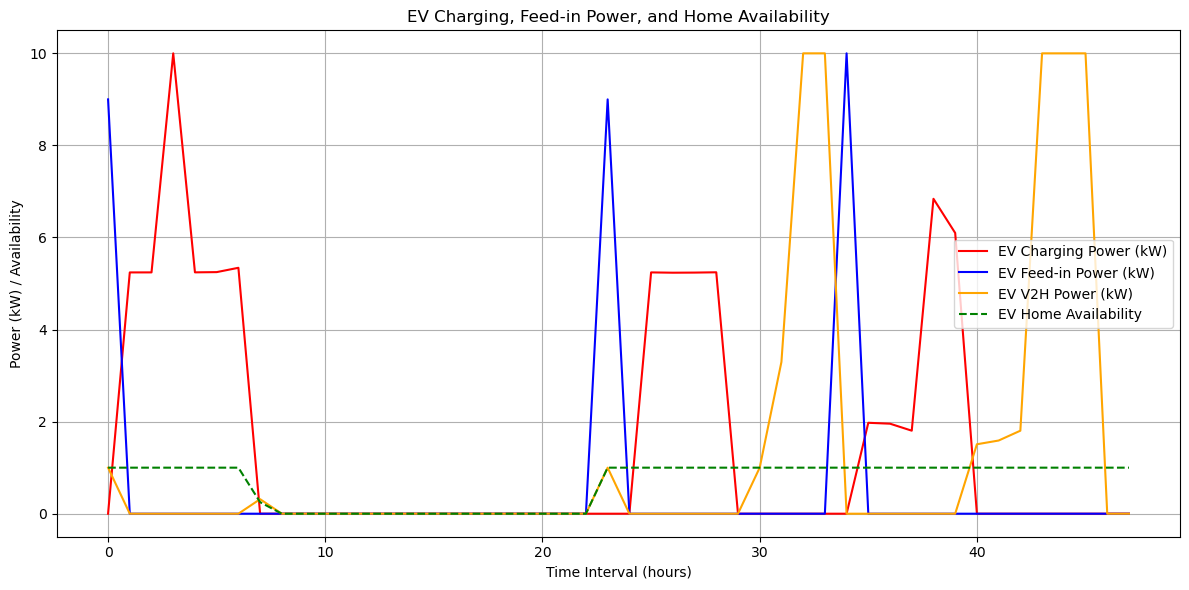

In [12]:
#plot 1 axis with ev charge, ev feed in v2h, ev feed in grid and one axis with availability of the ev at home
ev_home_availability = merged_data_summer['ev_home_availability'].values[:48]
# Create a new figure
plt.figure(figsize=(12, 6))
# Plot EV charging power
plt.plot(charging_ev_values[:48], label='EV Charging Power (kW)', color='red')
# Plot EV feed-in power
plt.plot(ev_feed_in_power_values[:48], label='EV Feed-in Power (kW)', color='blue')
# Plot EV V2H power
plt.plot(ev_v2h_power_values[:48], label='EV V2H Power (kW)', color='orange')
# Plot EV home availability
plt.plot(ev_home_availability[:48], label='EV Home Availability', color='green', linestyle='--')
# Add labels and title
plt.title('EV Charging, Feed-in Power, and Home Availability')
plt.xlabel('Time Interval (hours)')
plt.ylabel('Power (kW) / Availability')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#plot 1 axis with ev charge, ev feed in v2h, ev feed in grid and one axis with availability of the ev at home





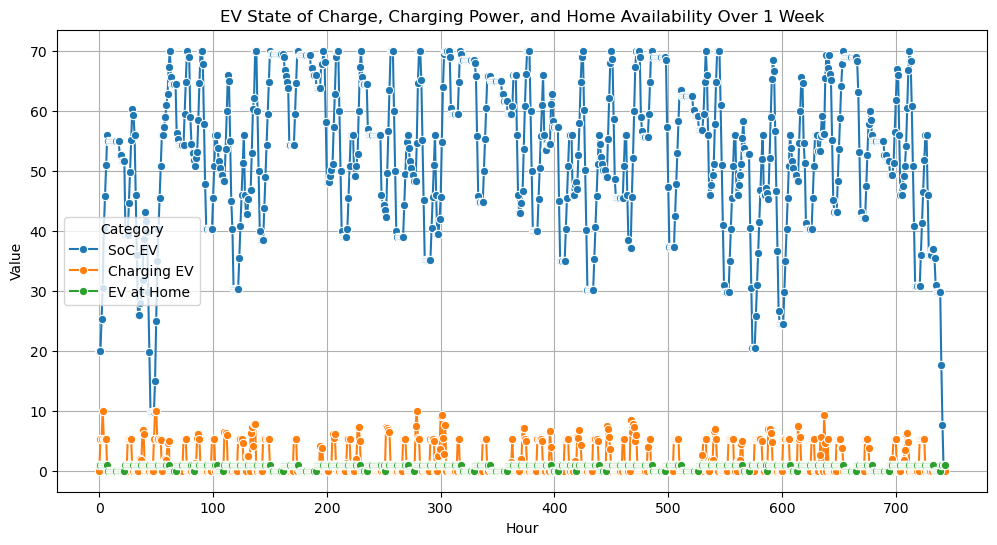

In [13]:
#plot the state of charge of the EV the driving and binary if at home or not 

data_ev = pd.DataFrame({
    'Hour': list(range(Time_interval)),
    'SoC EV': [soc_ev[t].X for t in range(Time_interval)],
    'Charging EV': [charging_ev[t].X for t in range(Time_interval)],
    'EV at Home': [merged_data_summer['ev_at_home_binary'][t] for t in range(Time_interval)]
})
# Melt for plotting
data_ev_melted = data_ev.melt(id_vars='Hour', var_name='Category', value_name='Value')
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_ev_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('EV State of Charge, Charging Power, and Home Availability Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)
plt.show()


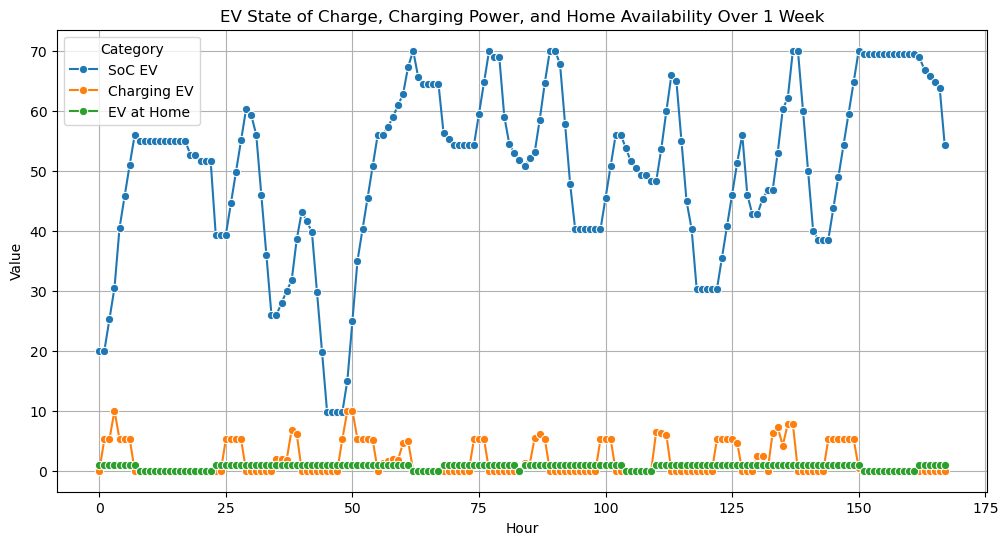

In [14]:
#same plot as before but just for one week
# Filter data for one week (first 168 hours)
data_ev_week = data_ev[data_ev['Hour'] < 168]
# Melt for plotting
data_ev_week_melted = data_ev_week.melt(id_vars='Hour', var_name='Category', value_name='Value')
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_ev_week_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('EV State of Charge, Charging Power, and Home Availability Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)
plt.show()


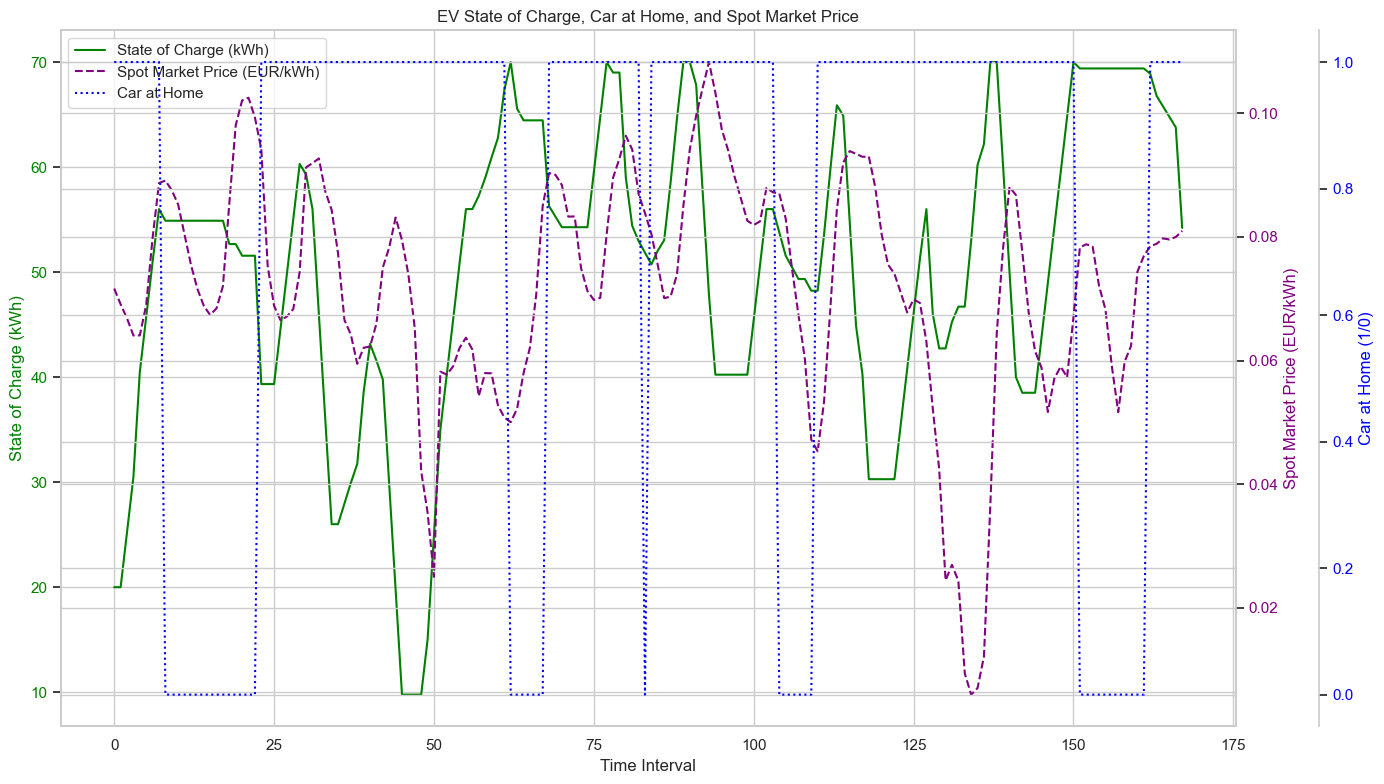

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Apply Seaborn style
sns.set(style="whitegrid")


# Define how many time steps you want to plot (7 days × 24 hours = 168 hours)
week_length = 7 * 24  # 168 hours
time = range(week_length)

# Prepare weekly-sliced data
soc = [soc_ev[t].X for t in time]
is_home = merged_data_summer['ev_at_home_binary'][:week_length]
spot_price = merged_data_summer['Spotmarket_(EUR/kWh)'][:week_length]


# Prepare your data
soc = [soc_ev[t].X for t in time]                         # EV state of charge
is_home = merged_data_summer['ev_at_home_binary'][:week_length]  # Binary: 1 if at home
spot_price = merged_data_summer['Spotmarket_(EUR/kWh)'][:week_length]

# Create figure and first axis (SOC)
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot SOC on ax1
line1 = ax1.plot(time, soc, label="State of Charge (kWh)", color="green")
ax1.set_ylabel("State of Charge (kWh)", color="green")
ax1.tick_params(axis='y', labelcolor="green")

# Create second y-axis for spot market price
ax2 = ax1.twinx()
line2 = ax2.plot(time, spot_price, label="Spot Market Price (EUR/kWh)", color="purple", linestyle="--")
ax2.set_ylabel("Spot Market Price (EUR/kWh)", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

# Create third y-axis for is_home
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Move third axis outward
line3 = ax3.plot(time, is_home, label="Car at Home", color="blue", linestyle=":")
ax3.set_ylabel("Car at Home (1/0)", color="blue")
ax3.tick_params(axis='y', labelcolor="blue")

# Combine legends from all axes
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

# Common plot settings
ax1.set_xlabel("Time Interval")
plt.title("EV State of Charge, Car at Home, and Spot Market Price")
plt.tight_layout()
plt.show()



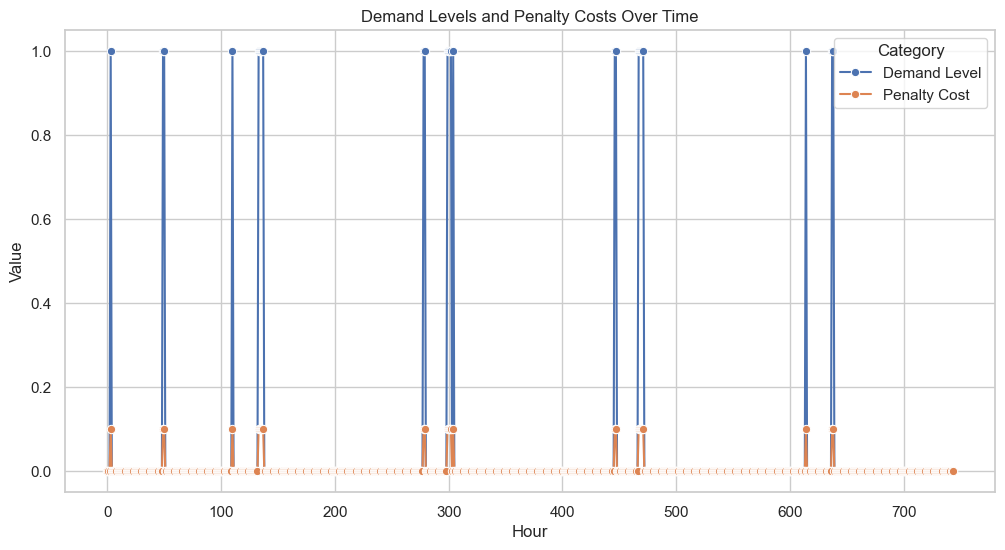

In [16]:
#plot the demand levels and the penalty costs
# Extract demand levels and penalty costs   
demand_levels = [demand_level[t].X for t in range(Time_interval)]
penalty_costs = [penalty_per_level[int(demand_levels[t])] for t in range(Time_interval)]
# Create a DataFrame for plotting
data_levels = pd.DataFrame({
    'Hour': list(range(Time_interval)),
    'Demand Level': demand_levels,
    'Penalty Cost': penalty_costs
})
# Melt the DataFrame for seaborn
data_levels_melted = data_levels.melt(id_vars='Hour', var_name='Category', value_name='Value')
# Plot the demand levels and penalty costs
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_levels_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('Demand Levels and Penalty Costs Over Time')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)
plt.show()

In [17]:
#print values of penalty costs when not 0 
non_zero_penalty_costs = [(t, penalty_costs[t]) for t in range(Time_interval) if penalty_costs[t] > 0]
print("Non-zero penalty costs (time, cost):")
for t, cost in non_zero_penalty_costs:
    print(f"Hour {t}: {cost:.2f} EUR")
# Print the demand levels
print("Demand levels (time, level):")
for t in range(Time_interval):
    print(f"Hour {t}: Level {demand_levels[t]}")

Non-zero penalty costs (time, cost):
Hour 3: 0.10 EUR
Hour 49: 0.10 EUR
Hour 50: 0.10 EUR
Hour 110: 0.10 EUR
Hour 133: 0.10 EUR
Hour 134: 0.10 EUR
Hour 135: 0.10 EUR
Hour 136: 0.10 EUR
Hour 137: 0.10 EUR
Hour 278: 0.10 EUR
Hour 279: 0.10 EUR
Hour 299: 0.10 EUR
Hour 300: 0.10 EUR
Hour 301: 0.10 EUR
Hour 302: 0.10 EUR
Hour 304: 0.10 EUR
Hour 446: 0.10 EUR
Hour 447: 0.10 EUR
Hour 467: 0.10 EUR
Hour 468: 0.10 EUR
Hour 469: 0.10 EUR
Hour 470: 0.10 EUR
Hour 471: 0.10 EUR
Hour 614: 0.10 EUR
Hour 637: 0.10 EUR
Hour 638: 0.10 EUR
Demand levels (time, level):
Hour 0: Level 0.0
Hour 1: Level 0.0
Hour 2: Level 0.0
Hour 3: Level 1.0
Hour 4: Level 0.0
Hour 5: Level 0.0
Hour 6: Level 0.0
Hour 7: Level 0.0
Hour 8: Level 0.0
Hour 9: Level 0.0
Hour 10: Level 0.0
Hour 11: Level 0.0
Hour 12: Level 0.0
Hour 13: Level 0.0
Hour 14: Level 0.0
Hour 15: Level 0.0
Hour 16: Level 0.0
Hour 17: Level 0.0
Hour 18: Level 0.0
Hour 19: Level 0.0
Hour 20: Level 0.0
Hour 21: Level 0.0
Hour 22: Level 0.0
Hour 23: Level 0.